# Transfer learning to predict COVID-19

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, Input
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from covid_flu import config, utils, time_series, plotting, models

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

In this notebook, we will attempt to take the work we have done previously on predicting seasonal influenza using RNNs and apply it to COVID-19 through the use of transfer learning.

#### Transfer learning

As already seen in our notebook exploring how RNNs can be used to predict flu (found [here](#)), these kinds of algorithms can be quite effective for even long-term predictions. However, a major limitation of sequence-to-sequence (seq2seq) models, and many powerful ML algorithms more broadly, is that they require a large amount of data. This is because the number of parameters (weights) can run into the tens of thousands even for simple models, let alone massive models with hundreds of millions of parameters.

One way to deal with the problem of data scarcity is transfer learning (TL). This is a deceptively simple technique whereby a model $M$ that has been trained using dataset $D$ for task $T$ is then re-used, entirely or in part, with fine-tuning or as-is, for another dataset $D'$ and/or task $T'$. For instance, in AC209b, we used a pre-trained MobileNet CNN to perform image classification.

There are several ways to do TL and which one we use depends heavily on two factors:

* How different our dataset $D'$ is from the dataset the model was trained on $D$
* How different our task $T'$ is from the task the model was trained on $T'$

If the tasks $T$ and $T'$ are very different, then it is likely necessary to modify the model architecture. In the case of a CNN trained for image classification, it is common practice to freeze the convolutional part, which can be seen as a feature extractor, and to change the fully connected network (FCN), which can be seen as a classifier. For some large pre-trained models, such as ImageNet or MobileNet, the convolutional base can be sufficiently complex to extract a rich enough set of features for a new FCN head to work with. This is referred to as *representation learning* -- using a neural network to convert the input into an abstract representation that is more useful for downstream tasks.

If datasets $D$ and $D'$ are very different, but $T$ and $T'$ are similar, then it is likely sufficient to fine-tune part or all of the model, while maintaining the same architecture.

In general, the more similar $D$ and $D'$, as well as $T$ and $T'$, then the more successful TL is likely to be.

#### Problem formulation

We have the following two datasets:

* $D$ = Reported weekly seasonal influenza cases from the last 10 years in the United States
* $D'$ = Reported daily COVID-19 cases from the beginning of 2020 in the United States

We have only one task: univariate time series forecasting.

We will attempt to apply TL by using a model trained on the flu data and then transferring it to COVID-19 data.

#### Outline of notebook

1. Data loading and preparation
2. Training seq2seq model on influenza
3. Transferring seq2seq model to COVID-19
    1. No TL
    2. Fine-tuning just the FCN head
    3. Fine-tuning the entire model

## Preparing data

In [3]:
df_flu = utils.load_flu_data()
df_covid = utils.load_covid_data()
display(df_flu.head())
display(df_covid.head())

,time,wili,state
0,2010-40,2.06514,Texas
1,2010-41,2.09394,Texas
2,2010-42,2.10072,Texas
3,2010-43,2.20655,Texas
4,2010-44,2.36381,Texas


,date,state,cases,total_cases
0,2020-01-21,Alabama,0.0,0.0
1,2020-01-22,Alabama,0.0,0.0
2,2020-01-23,Alabama,0.0,0.0
3,2020-01-24,Alabama,0.0,0.0
4,2020-01-25,Alabama,0.0,0.0


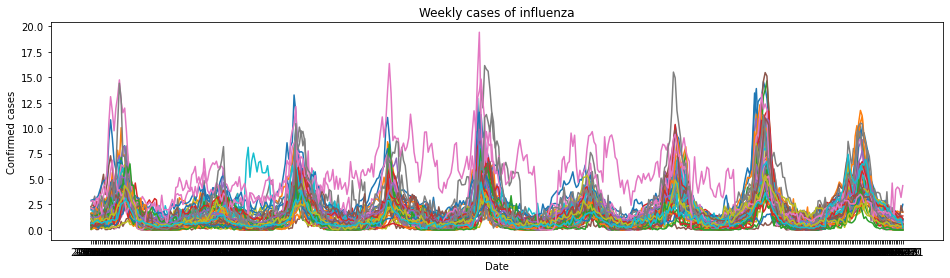

In [4]:
plt.figure(figsize=(16, 4))
plt.title("Weekly cases of influenza")
for state in df_flu['state'].unique():
    subset = df_flu.query('state == @state')
    plt.plot(subset['time'], subset['wili'])
plt.ylabel("Confirmed cases")
plt.xlabel("Date")
plt.show()

For much of the year, there are no reported cases. Because we will be splitting data using a cutoff date (before and after) rather than a random train/test/val split, we don't want most of the training data to have very low case counts.

In [5]:
df_covid = df_covid[df_covid['total_cases'] >= 10]

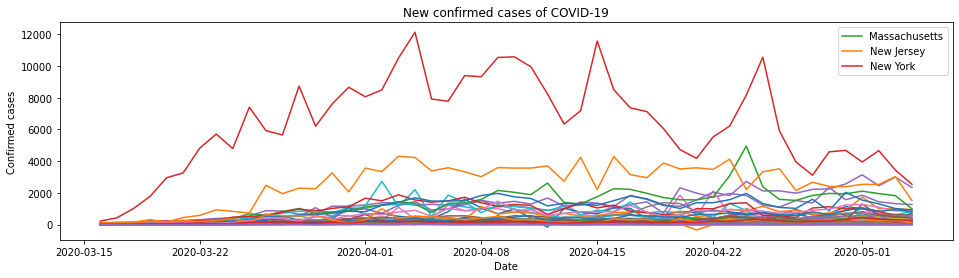

In [6]:
plt.figure(figsize=(16, 4))
plt.title("New confirmed cases of COVID-19")
for state in df_covid['state'].unique():
    subset = df_covid.query('state == @state').query('date > @pd.to_datetime("2020-03-15")')
    if (subset['cases'] > 4000).any():
        plt.plot(subset['date'], subset['cases'], label=state)
    else:
        plt.plot(subset['date'], subset['cases'])
plt.ylabel("Confirmed cases")
plt.xlabel("Date")
plt.legend()
plt.show()

#### Notable differences between the two datasets

The flu and COVID-19 datasets might be alike in that they are both diseases that are quite contagious and can follow exponential growth trends, it is evidence from the two time series that they are both quite different in terms of their progression in the population. There are also important differences between the datasets themselves, irrespective of the underlying diseases.

* **Temporal resolution**: Flu data are collected weekly, allowing for more shap differences between individual time points, whereas COVID data are reported daily
* **Trajectory**: The flu tends to follow a pattern of steep peaks spaced out by wide troughs, which repeats throughout the year. COVID, on the other hand, exhibits a slow and steady
* **Completeness**: The flu data cover 10 years completely, whereas the COVID data do not even cover half a year. Thus, the patterns that might be noticed in the flu data are not available for forecasting COVID.

These differences will need to be mitigated where possible or accepted as limitations in this methodology. Later on, we will attempt to mitigate the effect of the first (temporal resolution) whereas the other two are likely better dealt with through more parametric methods (such as agent-based models).

## Preprocessing data

In [7]:
# Some hyperparameters
HISTORY_SIZE = 25
TARGET_SIZE = 5
BATCH_SIZE = 64
TEST_SIZE = 0.3
EPOCHS = 20

In [8]:
# Scaling
scaler_flu = StandardScaler()
scaler_covid = StandardScaler()
df_flu['wili'] = utils.scale_data(df_flu['wili'].values, scaler_flu)
df_covid['cases'] = utils.scale_data(df_covid['cases'].values, scaler_covid)

In [9]:
# Preparing tensorflow datasets
# Making train/val/test split
ds_train_flu, ds_val_flu, ds_test_flu, data_dict_flu = time_series.prepare_data(df_flu['wili'].values, 
                                                                                df_flu['state'].values,
                                                                                history_size=HISTORY_SIZE,
                                                                                target_size=TARGET_SIZE,
                                                                                batch_size=BATCH_SIZE,
                                                                                test_size=TEST_SIZE,
                                                                                teacher_forcing=True)

ds_train_covid, ds_val_covid, ds_test_covid, data_dict_covid = time_series.prepare_data(df_covid['cases'].values, 
                                                                                        df_covid['state'].values,
                                                                                        history_size=HISTORY_SIZE,
                                                                                        target_size=TARGET_SIZE,
                                                                                        batch_size=BATCH_SIZE,
                                                                                        test_size=TEST_SIZE,
                                                                                        teacher_forcing=True)

## Building a seq2seq model for flu

Building on the work in our RNN notebook that focused entirely on flu, we use a seq2seq RNN consisting of a 3-layer LSTM encoder and a 1-layer decoder. We train using teacher forcing, where the decoder predicts a single point at a time and the next point fed to the decoder is the true value of the time series, rather than what was predicted on the previous step.

In [26]:
NUM_ENCODER_LAYERS = 2
HIDDEN_SIZE = 16
PRE_OUTPUT_DENSE_SIZE = 16

In [27]:
seq2seq_model = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=16,
                               pre_output_dense_size=16,
                               num_encoder_layers=2)
seq2seq_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_25[0][0]                   
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]       

In [28]:
history_flu = seq2seq_model.fit(ds_train_flu, validation_data=ds_val_flu, epochs=10)

Train for 236 steps, validate for 51 steps
Epoch 1/10
236/236 [==============================] - 17s 74ms/step - loss: 0.2191 - val_loss: 0.1076
Epoch 2/10
236/236 [==============================] - 11s 45ms/step - loss: 0.1047 - val_loss: 0.0878
Epoch 3/10
236/236 [==============================] - 9s 38ms/step - loss: 0.0982 - val_loss: 0.0843
Epoch 4/10
236/236 [==============================] - 9s 39ms/step - loss: 0.0951 - val_loss: 0.0830
Epoch 5/10
236/236 [==============================] - 8s 33ms/step - loss: 0.0949 - val_loss: 0.0804
Epoch 6/10
236/236 [==============================] - 8s 36ms/step - loss: 0.0945 - val_loss: 0.0816
Epoch 7/10
236/236 [==============================] - 9s 37ms/step - loss: 0.0940 - val_loss: 0.0833
Epoch 8/10
236/236 [==============================] - 8s 33ms/step - loss: 0.0939 - val_loss: 0.0793
Epoch 9/10
236/236 [==============================] - 9s 39ms/step - loss: 0.0935 - val_loss: 0.0818
Epoch 10/10
236/236 [=========================

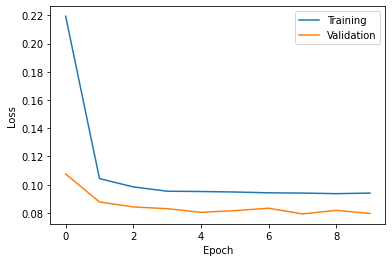

In [29]:
plotting.plot_history(history_flu)

In [30]:
states = ['New York', 'California', 'Texas', 'Colorado', 'Washington']

def plot_example_states(states, model, data_dict, scaler, pred_window=5):
    fig, axs = plt.subplots(len(states), 3, figsize=(3.5 * len(states), 16))
    for i, state in enumerate(states):
        for j, split in enumerate(['train', 'val', 'test']):
            plotting.plot_seq2seq_preds(model, data_dict, state, pred_window, scaler=scaler_flu, split=split, ax=axs[i, j])
            axs[i, j].set_title(state)
    plt.show()

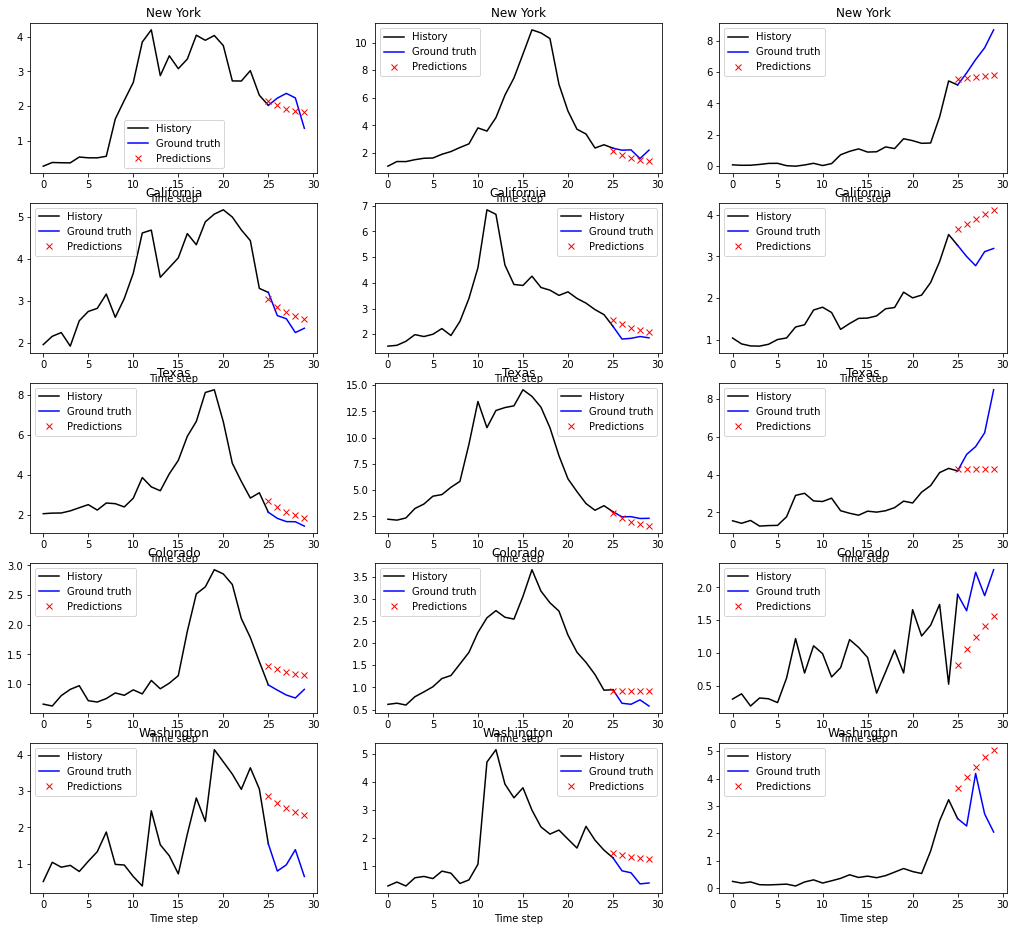

In [31]:
plot_example_states(states, seq2seq_model, data_dict_flu, scaler_flu)

Unfortunately, the results are not particularly encouraging for the flu model. It does not appear as though the model is very good at picking up on small micro-trends and fluctuations in the number of influenza cases, beyond what a simple moving average or autoregressive model could do. However, it is possible that the model might still be good for COVID, since the COVID time series shows less cyclical spikes and more constant increases

## Transfer learning

We will try to model COVID in three ways:

1. Identical model to flu, training from scratch
2. The flu model without any retraining
3. The flu model with the FCN head fine-tuned

### Training from scratch

In [32]:
seq2seq_covid_scratch = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=HIDDEN_SIZE,
                               pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                               num_encoder_layers=NUM_ENCODER_LAYERS)
seq2seq_covid_scratch.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_29[0][0]                   
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]       

In [33]:
history_cov_scratch = seq2seq_covid_scratch.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)

Train for 14 steps, validate for 4 steps
Epoch 1/10
14/14 [==============================] - 7s 482ms/step - loss: 1.6433 - val_loss: 0.5118
Epoch 2/10
14/14 [==============================] - 1s 36ms/step - loss: 1.3332 - val_loss: 0.2572
Epoch 3/10
14/14 [==============================] - 0s 35ms/step - loss: 1.0274 - val_loss: 0.2167
Epoch 4/10
14/14 [==============================] - 0s 33ms/step - loss: 0.8401 - val_loss: 0.1878
Epoch 5/10
14/14 [==============================] - 0s 33ms/step - loss: 0.6372 - val_loss: 0.1316
Epoch 6/10
14/14 [==============================] - 0s 33ms/step - loss: 0.4515 - val_loss: 0.0986
Epoch 7/10
14/14 [==============================] - 0s 34ms/step - loss: 0.3006 - val_loss: 0.1423
Epoch 8/10
14/14 [==============================] - 0s 33ms/step - loss: 0.2082 - val_loss: 0.1866
Epoch 9/10
14/14 [==============================] - 0s 33ms/step - loss: 0.1636 - val_loss: 0.2416
Epoch 10/10
14/14 [==============================] - 0s 32ms/step -

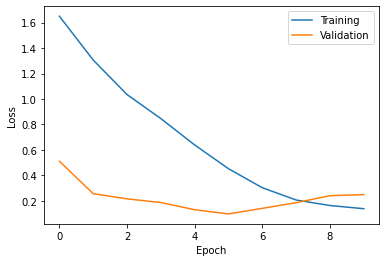

In [34]:
plotting.plot_history(history_cov_scratch)

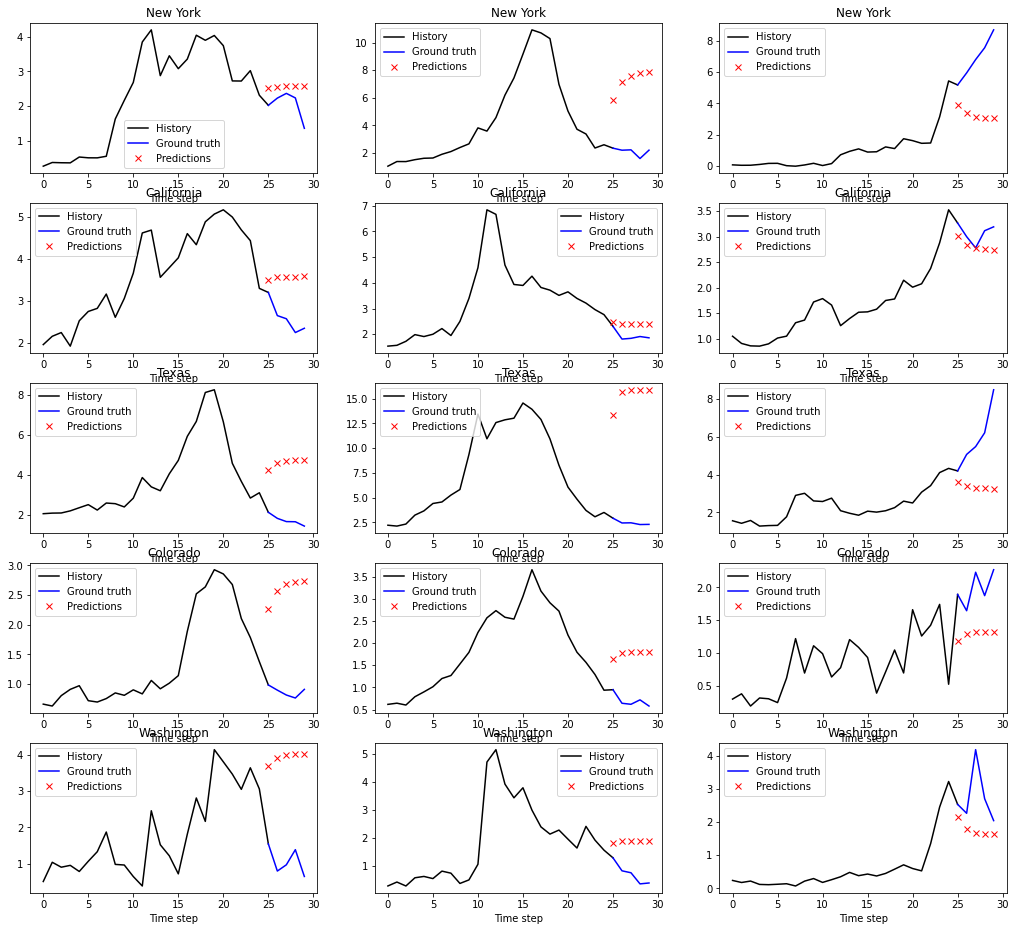

In [35]:
plot_example_states(states, seq2seq_covid_scratch, data_dict_flu, scaler_covid)

These results are quite poor. As evident from the plot of the loss, while the training loss goes does the validation loss barely moves. Let's compare against the original, untuned flu model.

### Just using the flu model

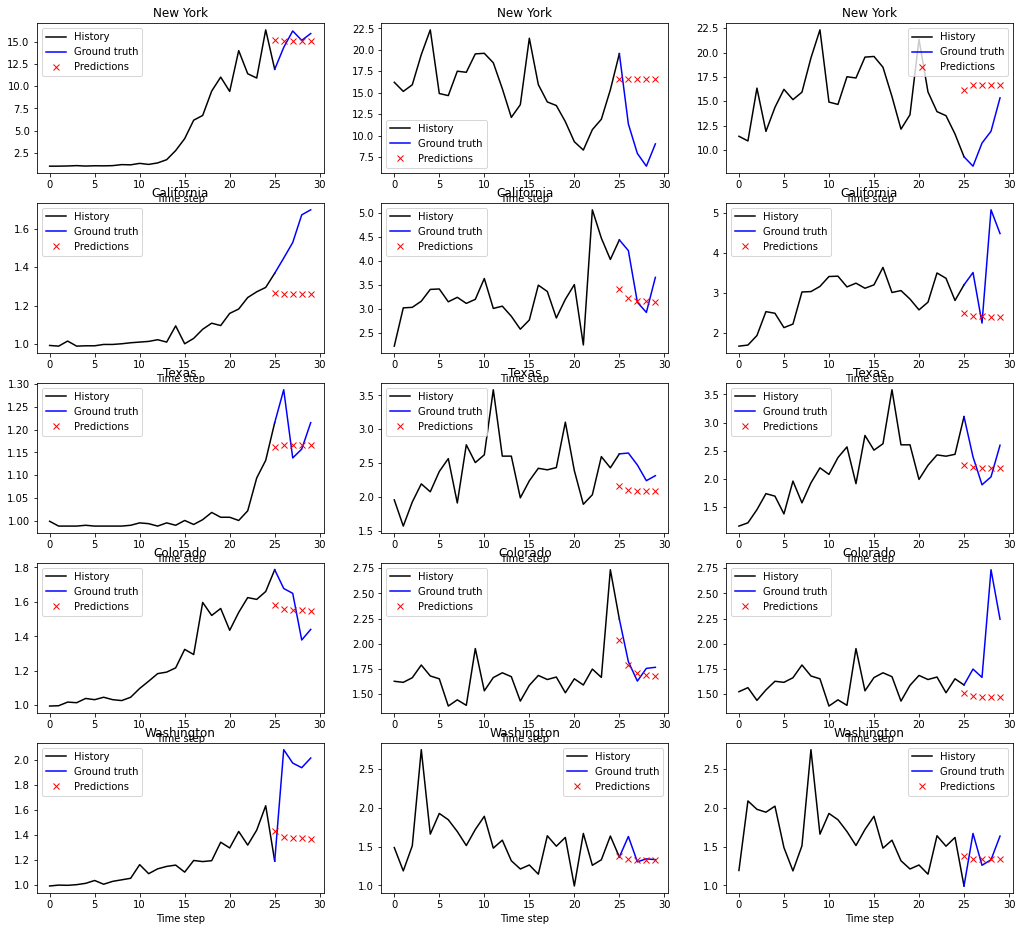

In [36]:
plot_example_states(states, seq2seq_covid_scratch, data_dict_covid, scaler_covid)

This seems better than the COVID-from-scratch model, but not great still. Maybe we can take advantage of TL to improve performance.

### Fine-tuning just the head (transfer learning)

To perform TL, we use a custom-written method in the `Seq2Seq` class: `transfer()`. This method creates a new `Seq2Seq` object with all the trained weights copied over. As well, we can specify that we want the weights frozen except for the FCN head.

In [37]:
seq2seq_covid_finetune = seq2seq_model.transfer(freeze=True)
seq2seq_covid_finetune.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_33[0][0]                   
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]       

Notice how many fewer parameters we have to train! We went from over 5,000 to closer to 250!

Train for 14 steps, validate for 4 steps
Epoch 1/10
14/14 [==============================] - 8s 573ms/step - loss: 0.2486 - val_loss: 0.1067
Epoch 2/10
14/14 [==============================] - 1s 40ms/step - loss: 0.1944 - val_loss: 0.1187
Epoch 3/10
14/14 [==============================] - 1s 40ms/step - loss: 0.1783 - val_loss: 0.1307
Epoch 4/10
14/14 [==============================] - 1s 41ms/step - loss: 0.1676 - val_loss: 0.1268
Epoch 5/10
14/14 [==============================] - 1s 48ms/step - loss: 0.1594 - val_loss: 0.1418
Epoch 6/10
14/14 [==============================] - 1s 44ms/step - loss: 0.1538 - val_loss: 0.1244
Epoch 7/10
14/14 [==============================] - 1s 45ms/step - loss: 0.1513 - val_loss: 0.1200
Epoch 8/10
14/14 [==============================] - 1s 41ms/step - loss: 0.1533 - val_loss: 0.1301
Epoch 9/10
14/14 [==============================] - 1s 41ms/step - loss: 0.1482 - val_loss: 0.1289
Epoch 10/10
14/14 [==============================] - 1s 45ms/step -

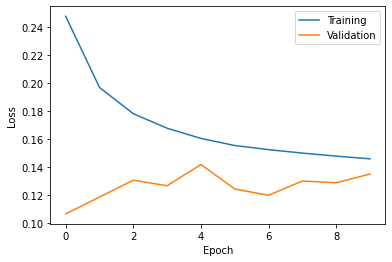

In [38]:
history_cov_finetune = seq2seq_covid_finetune.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)
plotting.plot_history(history_cov_finetune)

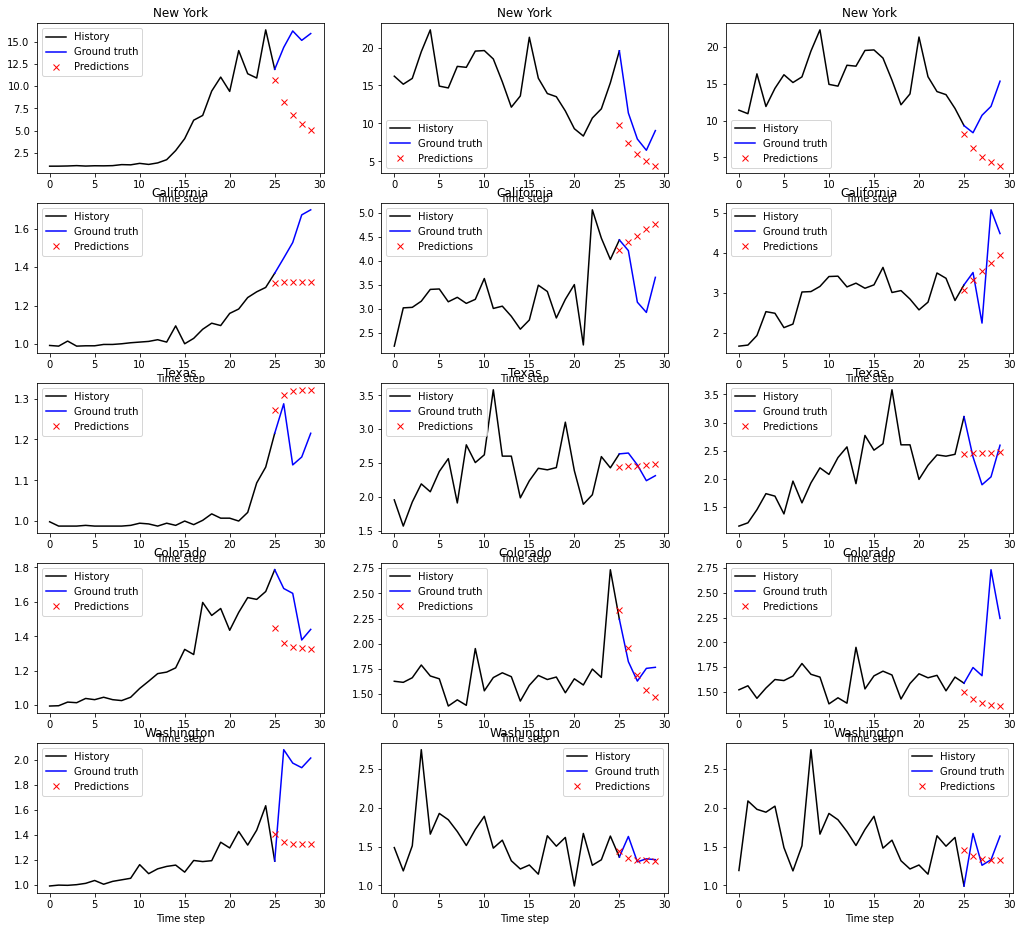

In [39]:
plot_example_states(states, seq2seq_covid_finetune, data_dict_covid, scaler_covid)

### Fine-tuning the entire network

Finally we can see whether we are able to fine-tune the entire network for the task of predicting COVID-19. One major reason why this is unlikely to work is because the COVID dataset is much smaller than the flu dataset, whereas the network is more in proportion to the flu dataset in terms of the total number of weights.

In [40]:
seq2seq_covid_tuneall = seq2seq_model.transfer(freeze=False)
seq2seq_covid_tuneall.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 25, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm0 (LSTM)            [(None, 25, 16), (No 1152        input_41[0][0]                   
__________________________________________________________________________________________________
encoder_lstm1 (LSTM)            [(None, 25, 16), (No 2112        encoder_lstm0[0][0]              
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 32)           0           encoder_lstm1[0][1]              
                                                                 encoder_lstm1[0][2]       

Train for 14 steps, validate for 4 steps
Epoch 1/10
14/14 [==============================] - 9s 608ms/step - loss: 0.1794 - val_loss: 0.1084
Epoch 2/10
14/14 [==============================] - 1s 46ms/step - loss: 0.1223 - val_loss: 0.1258
Epoch 3/10
14/14 [==============================] - 1s 55ms/step - loss: 0.1132 - val_loss: 0.1644
Epoch 4/10
14/14 [==============================] - 1s 55ms/step - loss: 0.1088 - val_loss: 0.1101
Epoch 5/10
14/14 [==============================] - 1s 56ms/step - loss: 0.1065 - val_loss: 0.1057
Epoch 6/10
14/14 [==============================] - 1s 49ms/step - loss: 0.1040 - val_loss: 0.1081
Epoch 7/10
14/14 [==============================] - 1s 45ms/step - loss: 0.1032 - val_loss: 0.0980
Epoch 8/10
14/14 [==============================] - 1s 53ms/step - loss: 0.1031 - val_loss: 0.0977
Epoch 9/10
14/14 [==============================] - 1s 41ms/step - loss: 0.0999 - val_loss: 0.1006
Epoch 10/10
14/14 [==============================] - 1s 51ms/step -

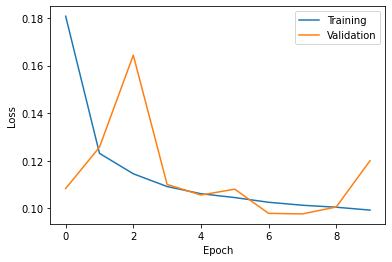

In [41]:
history_cov_tuneall = seq2seq_covid_tuneall.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)
plotting.plot_history(history_cov_tuneall)

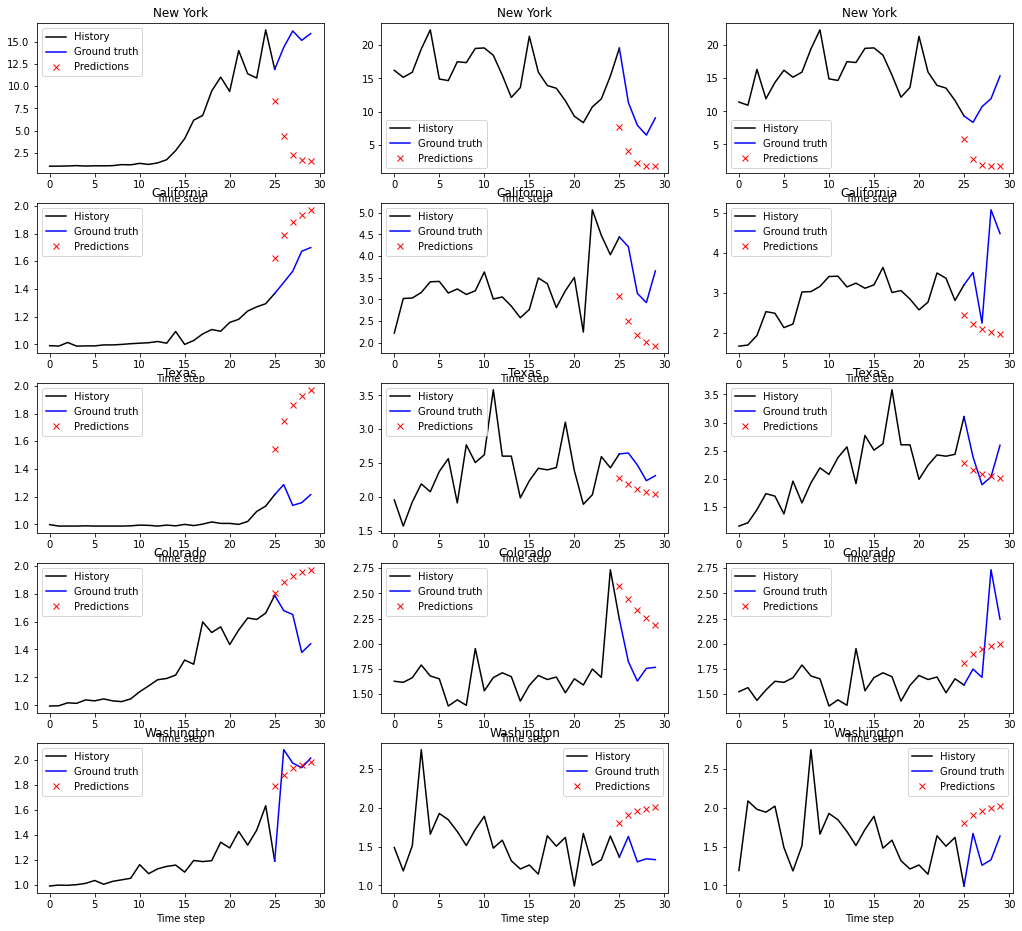

In [42]:
plot_example_states(states, seq2seq_covid_tuneall, data_dict_covid, scaler_covid)

Superficially, it looks like the fine-tuned model performed best! (Although "best" is a relative term)

### Comparing models

We can look at the RMSE of the different COVID-19 models to see whether TL admits any advantage (although it might not seem like it from the figures)

In [49]:
y_test.squeeze(2).shape

(193, 5)

In [47]:
X_test.shape

(193, 25, 1)

In [57]:
X_test = data_dict_covid['X_test']
y_test = data_dict_covid['y_test']
models = [seq2seq_model, seq2seq_covid_scratch, seq2seq_covid_finetune, seq2seq_covid_scratch]
names = ['Base flu model', 'Base COVID model', 'Fine-tuned', 'Full tuned']
rmses = []
for model in models:
    rmse = utils.calc_rmse_model(y_test, X_test, model, scaler_covid)
    rmses.append(rmse)

In [60]:
pd.DataFrame({
    'Model': names,
    'RMSE': rmses
}).set_index('Model')

,RMSE
Model,
Base flu model,755.489648
Base COVID model,909.361727
Fine-tuned,852.959140
Full tuned,909.361727


## Other ways to improve the models

In this section, we will briefly cover several possible improvements to the models. In short, the improvements are:

1. Training the flu model on a dataset resampled to daily, rather than weekly frequency
2. Adding state-specific tags (state embeddings)

#### Resampling

In [ ]:
# Resampling the flu data to be daily resolution
from datetime import datetime, timedelta

def parse_date(d):
    yy, ww = d.split('-')
    ystart = datetime(year=int(yy), month=1, day=1)
    dd = ystart + timedelta(days=7 * int(ww))
    return dd


df_flu_res = df_flu.copy()
df_flu_res['time'] = df_flu_res['time'].apply(parse_date)
df_flu_res = df_flu_res.set_index(pd.DatetimeIndex(df_flu_res['time'])).drop('time', axis=1)
df_flu_res = df_flu_res.groupby('state').apply(lambda group: (group
                                                              .resample('D')
                                                              .interpolate(method='linear')))
df_flu_res = df_flu_res.drop('state', axis=1).reset_index()

In [1]:
for state in ['California', 'New York', 'Colorado']:
    plt.plot(df_fu_res['time'], df_flu_res[df_flu_res['state'] == state]['wili'][-500:], label=state)
plt.legend()
plt.title("Resampled to 1-day intervals using linear interpolation")
plt.xlabel("Day")
ply.ylabel("WILI")
plt.show()

SyntaxError: invalid syntax (<ipython-input-1-558c09a8796b>, line 1)

In [ ]:
ds_train_flu_res, ds_val_flu_res, ds_test_flu_res, data_dict_flu_res = \
    time_series.prepare_data(df_flu_res['wili'].values, 
                             df_flu_res['state'].values,
                             history_size=HISTORY_SIZE,
                             target_size=TARGET_SIZE,
                             batch_size=BATCH_SIZE,
                             test_size=TEST_SIZE,
                             teacher_forcing=True)

In [ ]:
seq2seq_flu_res = models.Seq2Seq(history_length=HISTORY_SIZE,
                                 target_length=TARGET_SIZE,
                                 hidden_size=32,
                                 pre_output_dense_size=16,
                                 num_encoder_layers=3,
                                 dropout=0.)
seq2seq_flu_res.summary()

In [ ]:
history_flu_res = seq2seq_flu_res.fit(ds_train_flu_res, validation_data=ds_val_flu_res, epochs=10)

In [ ]:
plotting.plot_history(history_flu_res)

In [ ]:
seq2seq_covid_res = seq2seq_flu_res.transfer(freeze=True)
seq2seq_covid_res.summary()

In [ ]:
history_covid_res = seq2seq_covid_res.fit(ds_train_covid, validation_data=ds_val_covid, epochs=EPOCHS)

In [ ]:
plot_example_states(states, seq2seq_covid_res, data_dict_covid, scaler_covid)

### Using state information

Until now, we have been treating each state's time series as if it is drawn from the same distribution, conditioned on the observed history:

$$y_t \sim P(y|y_{1:t-1})$$

where $y_t$ is the next predicted point in the time series, and $y_{t:t-1}$ is the observed history of length $H$ (in our case, 25). However, it should be clear from the existing plots of both COVID and flu that the states behave quite differently. For instance, New York's COVID-19 outbreak is famously different from that of the other states. In order to account for this, we will attempt to condition the model on the state that is being predicted:

$$
y_t \sim P(y|y_{1:t-1}, s)
$$

where $s$ is the state that the time series is taken from. Similar to the homework on conditional variational autoencoders (CVAEs), we will add this information to the encoded representation of the time series in the form of an *embedding*. This will be accomplished using Keras' **Embedding** layer, which conveniently maps from an index of a categorical variable to a fixed-length dense vector. This vector is then concatenated to the final cell and hidden states of the encoder LSTM, passed through a dense layer, and used to initialize the hidden state of the decoder RNN.

#### Preparing state data

In [ ]:
# Making train/val/test split
# Adding *_s for "state"
ds_train_flu_s, ds_val_flu_s, ds_test_flu_s, data_dict_flu_s = \
    time_series.prepare_data(df_flu['wili'].values, 
                             df_flu['state'].values,
                             history_size=HISTORY_SIZE,
                             target_size=TARGET_SIZE,
                             batch_size=BATCH_SIZE,
                             test_size=TEST_SIZE,
                             teacher_forcing=True,
                             states=True)

ds_train_covid_s, ds_val_covid_s, ds_test_covid_s, data_dict_covid_s = \
time_series.prepare_data(df_covid['cases'].values, 
                         df_covid['state'].values,
                         history_size=HISTORY_SIZE,
                         target_size=TARGET_SIZE,
                         batch_size=BATCH_SIZE,
                         test_size=TEST_SIZE,
                         teacher_forcing=True,
                         states=True)

In [ ]:
seq2seq_flu_s = models.Seq2Seq(history_length=HISTORY_SIZE,
                               target_length=TARGET_SIZE,
                               hidden_size=HIDDEN_SIZE,
                               pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE,
                               num_encoder_layers=2,
                               dropout=0.2,
                               state_embed_size=32)
seq2seq_flu_s.summary()

In [ ]:
history_flu_s = seq2seq_flu_s.fit(ds_train_flu_s, validation_data=ds_val_flu_s, epochs=EPOCHS)

In [ ]:
plotting.plot_history(history_flu_s)

In [ ]:
plot_example_states(states, seq2seq_flu_s, data_dict_flu_s, scaler_flu)

In [ ]:
state2idx = {s: i for i, s in enumerate(np.unique(df_flu['state']))}

#### Examining the embeddings

Just like word or attribute embeddings, it might be worthwhile to examine these embeddings to see if any interesting patterns can be uncovered.

In [ ]:
embeds = []
for state, idx in state2idx.items():
    embed = seq2seq_flu_s.state_embed_model(np.array([[idx]]))
    embeds.append(embed.numpy().flatten())
embeds = np.stack(embeds, 0)

In [ ]:
# PCA clustering
pca = PCA(n_components=2)
embeds_pca = pca.fit_transform(embeds)

plt.figure(figsize=(20, 12))
plt.scatter(embeds_pca[:, 0], embeds_pca[:, 1], s=3)
for state, idx in state2idx.items():
    plt.annotate(state, (embeds_pca[idx, 0], embeds_pca[idx, 1]), rotation=-30, size=12)

## Conclusion